In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

In [3]:
AVOGADROS_NUMBER = 6.022140857e23
HARTREE_TO_EV = 27.211386024367243
EV_TO_JOULE = 1.6021766208e-19
JOULE_TO_KCAL = 1 / 4184.0
HARTREE_TO_JOULE = HARTREE_TO_EV * EV_TO_JOULE
HARTREE_TO_KCALPERMOL = HARTREE_TO_JOULE * JOULE_TO_KCAL * AVOGADROS_NUMBER

def hartree2kcalpermol(x):
    r"""Hartree to kJ/mol conversion factor from CODATA 2014"""
    return x * HARTREE_TO_KCALPERMOL

In [4]:
df = pd.read_parquet('2xr_1x-first_energies-forces_full.pq')
df.iloc[0]

id                                                              C10H10-0-idx0
species                     [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...
dataset_energy                                                    -386.884014
dataset_force_magnitudes    [0.13925783606396697, 0.0953586765287354, 0.07...
energy_mean                                                       -386.879242
energy_qbc                                                           0.000182
atomic_energies             [[-0.2980835735797882, -0.28596869111061096, -...
mean_atomic_energies        [-0.2790623903274536, -0.27069181203842163, -0...
stdev_atomic_energies       [0.010355229489505291, 0.0072312382981181145, ...
force_magnitudes            [[0.16015008091926575, 0.09561650454998016, 0....
force_relative_stdev        [0.027946410700678825, 0.0497141107916832, 0.0...
force_relative_range        [0.0848284587264061, 0.12420666217803955, 0.11...
mean_relative_stdev                                             

In [5]:
atom_types = {1: "H", 6: "C", 7: "N", 8: "O"}

df["energy_mean"] = df["energy_mean"].apply(hartree2kcalpermol)
df["energy_qbc"] = df["energy_qbc"].apply(hartree2kcalpermol)
df["dataset_energy"] = df["dataset_energy"].apply(hartree2kcalpermol)

df["atomic_energies"] = df["atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["mean_atomic_energies"] = df["mean_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["stdev_atomic_energies"] = df["stdev_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])

df["force_magnitudes"] = df["force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["mean_force_mag"] = df["force_magnitudes"].apply(lambda x: np.mean(np.array(x), axis=0))
df["dataset_force_magnitudes"] = df["dataset_force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])

df["energy_error"] = abs(df["dataset_energy"] - df["energy_mean"])
df["weighted_energy_error"] = np.abs(df["dataset_energy"] - df["energy_mean"]) / np.abs(df["dataset_energy"])


print("All energies and forces converted to kcal/mol!")


All energies and forces converted to kcal/mol!


In [6]:
df.iloc[:]['mean_relative_stdev'].mean()

np.float64(0.11156926684377041)

In [7]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (6.5, 4)
plt.rcParams["figure.dpi"] = 150

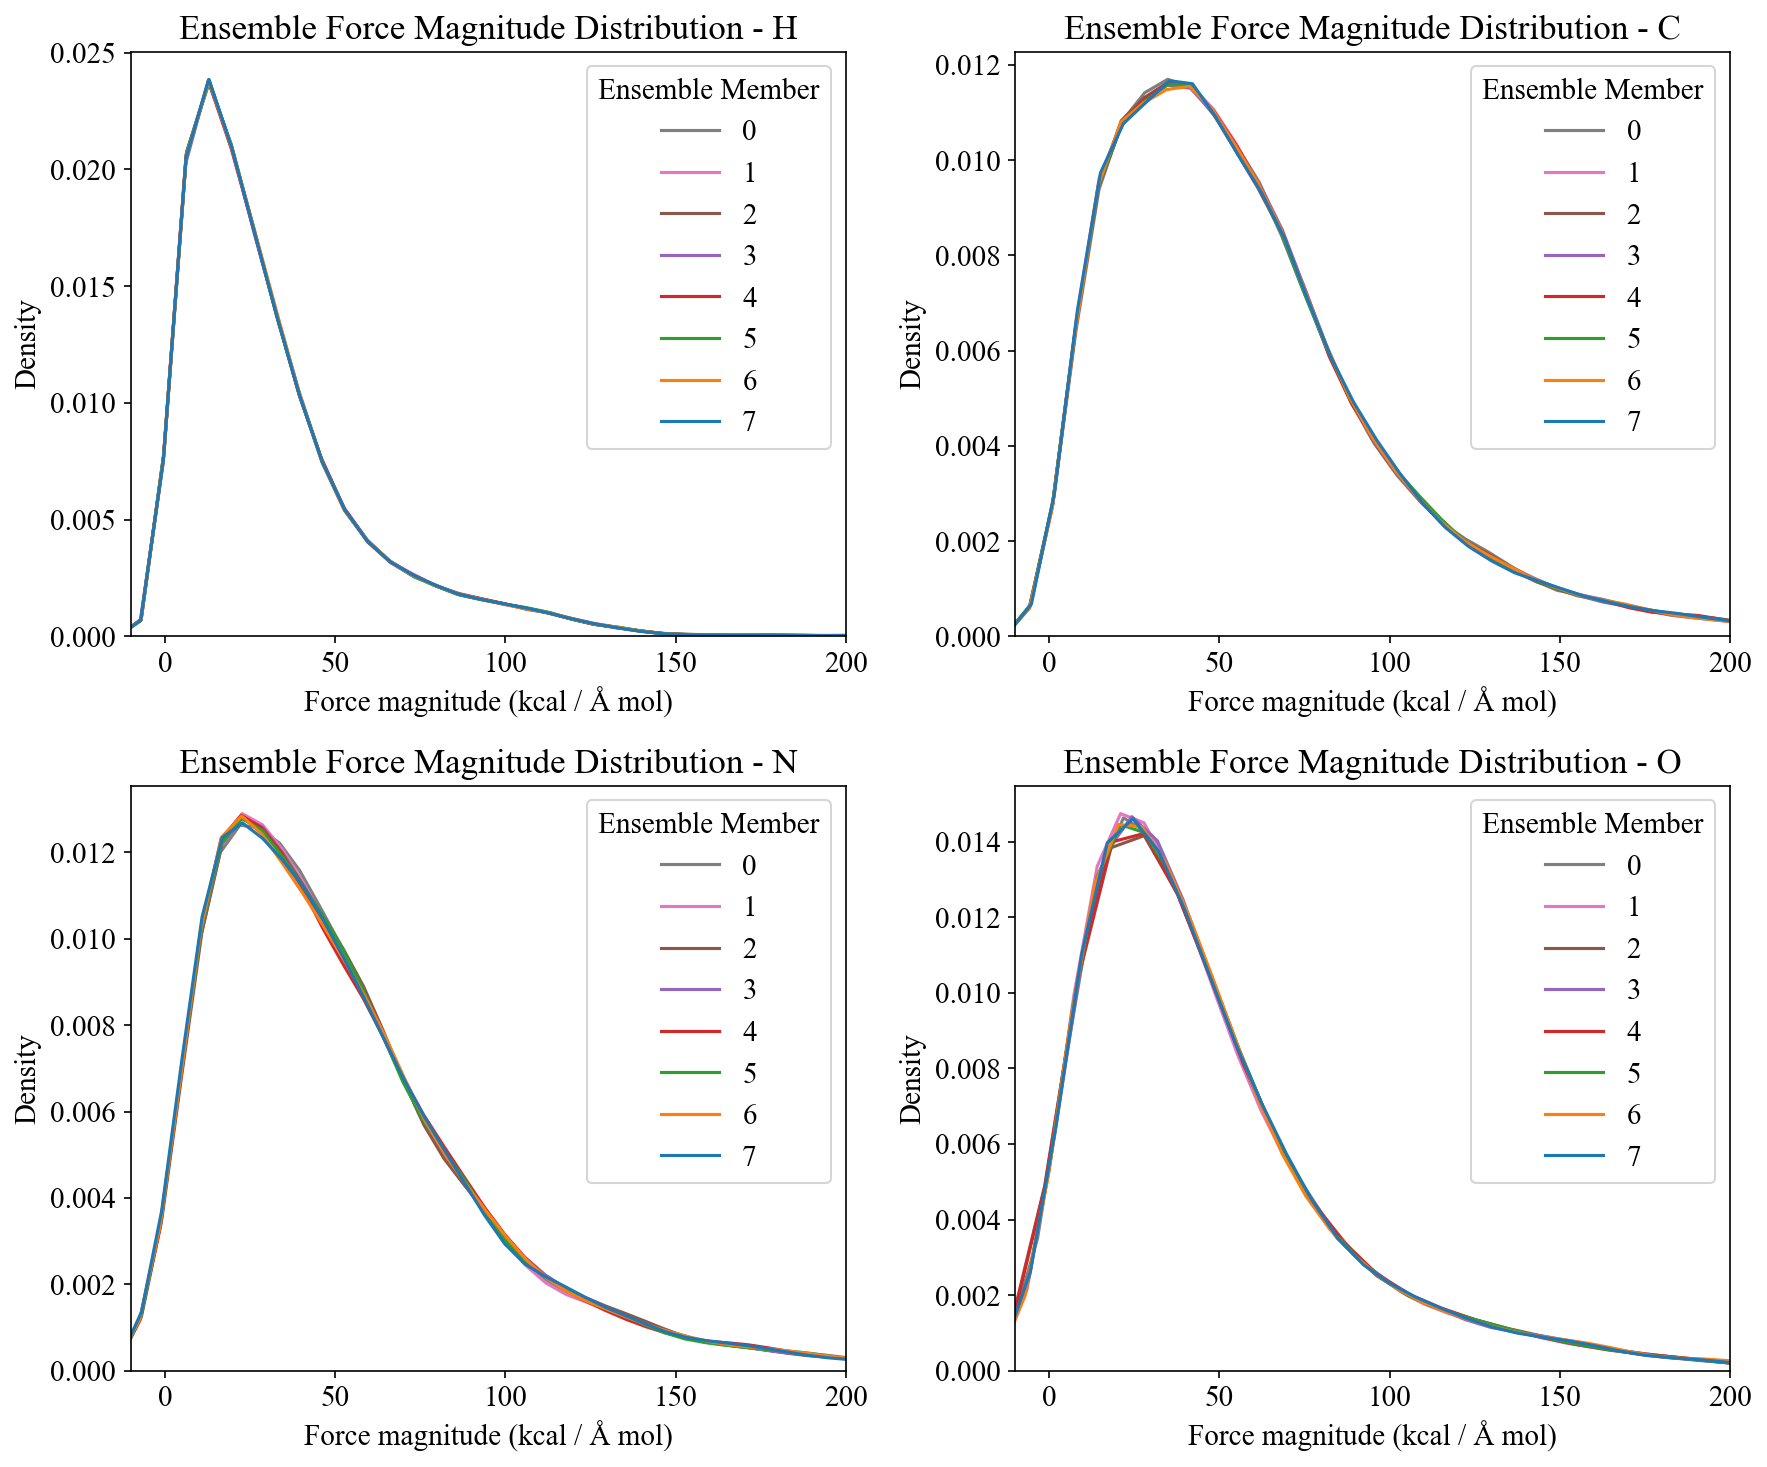

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

long_force_mag = []

for _, row in df.iterrows():
    species = row["species"]
    for i in range(8):  # 8 ensemble members
        force_magnitudes = row["force_magnitudes"][i]  # Shape [N_atoms]
        for atom_idx, energy in enumerate(force_magnitudes):
            long_force_mag.append([row["id"], i, species[atom_idx], energy])

df_long_force_mag = None
df_long_force_mag = pd.DataFrame(long_force_mag, columns=["id", "ensemble_member", "species", "force_magnitudes"])

for idx, (atom_num, atom_name) in enumerate(atom_types.items()):
    ax = axes[idx]

    df_filtered = df_long_force_mag[df_long_force_mag["species"] == atom_num]

    sns.kdeplot(data=df_filtered, x="force_magnitudes", hue="ensemble_member", ax=ax, palette="tab10", common_norm=False)
    ax.set_xlim(-10,200)
    ax.set_xlabel("Force magnitude (kcal / Å mol)")
    ax.set_ylabel("Density")
    ax.set_title(f"Ensemble Force Magnitude Distribution - {atom_name}")
    ax.legend(title="Ensemble Member", labels=df_long_force_mag["ensemble_member"].unique())

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
df.iloc[0]

id                                                              C10H10-0-idx0
species                     [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...
dataset_energy                                                 -242773.384193
dataset_force_magnitudes    [87.38561144354274, 59.83847293938178, 47.3917...
energy_mean                                                    -242770.389571
energy_qbc                                                           0.114157
atomic_energies             [[-187.05026643226753, -179.4480629077964, -19...
mean_atomic_energies        [-175.1142937368321, -169.86167655852762, -188...
stdev_atomic_energies       [6.498004608968412, 4.537670540024433, 5.80158...
force_magnitudes            [[100.49569302106978, 60.00026246534715, 45.71...
force_relative_stdev        [0.027946410700678825, 0.0497141107916832, 0.0...
force_relative_range        [0.0848284587264061, 0.12420666217803955, 0.11...
mean_relative_stdev                                             

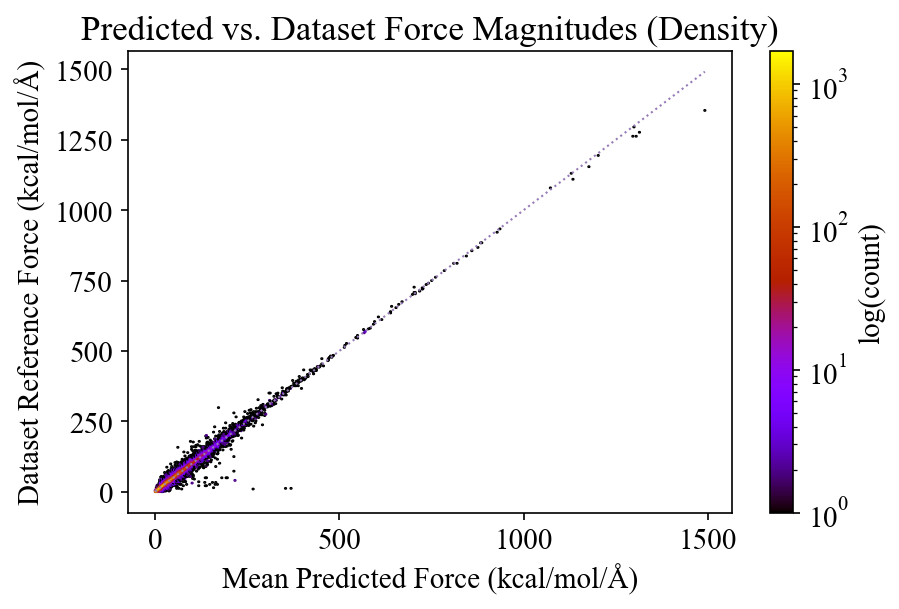

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

force_pairs = [
    (pred, ref)
    for pred_list, ref_list in zip(df["mean_force_mag"], df["dataset_force_magnitudes"])
    for pred, ref in zip(pred_list, ref_list)  # Unpacking per atom
]

pred_forces, ref_forces = map(np.array, zip(*force_pairs))

plt.hexbin(pred_forces, ref_forces, gridsize=500, cmap="gnuplot", bins="log")
plt.colorbar(label="log(count)")


plt.xlabel("Mean Predicted Force (kcal/mol/Å)")
plt.ylabel("Dataset Reference Force (kcal/mol/Å)")
plt.title("Predicted vs. Dataset Force Magnitudes (Density)")

min_force, max_force = min(pred_forces), max(pred_forces)
plt.plot([min_force, max_force], [min_force, max_force], linewidth=1, alpha=1, linestyle=":", color='#967BB6')

plt.show()


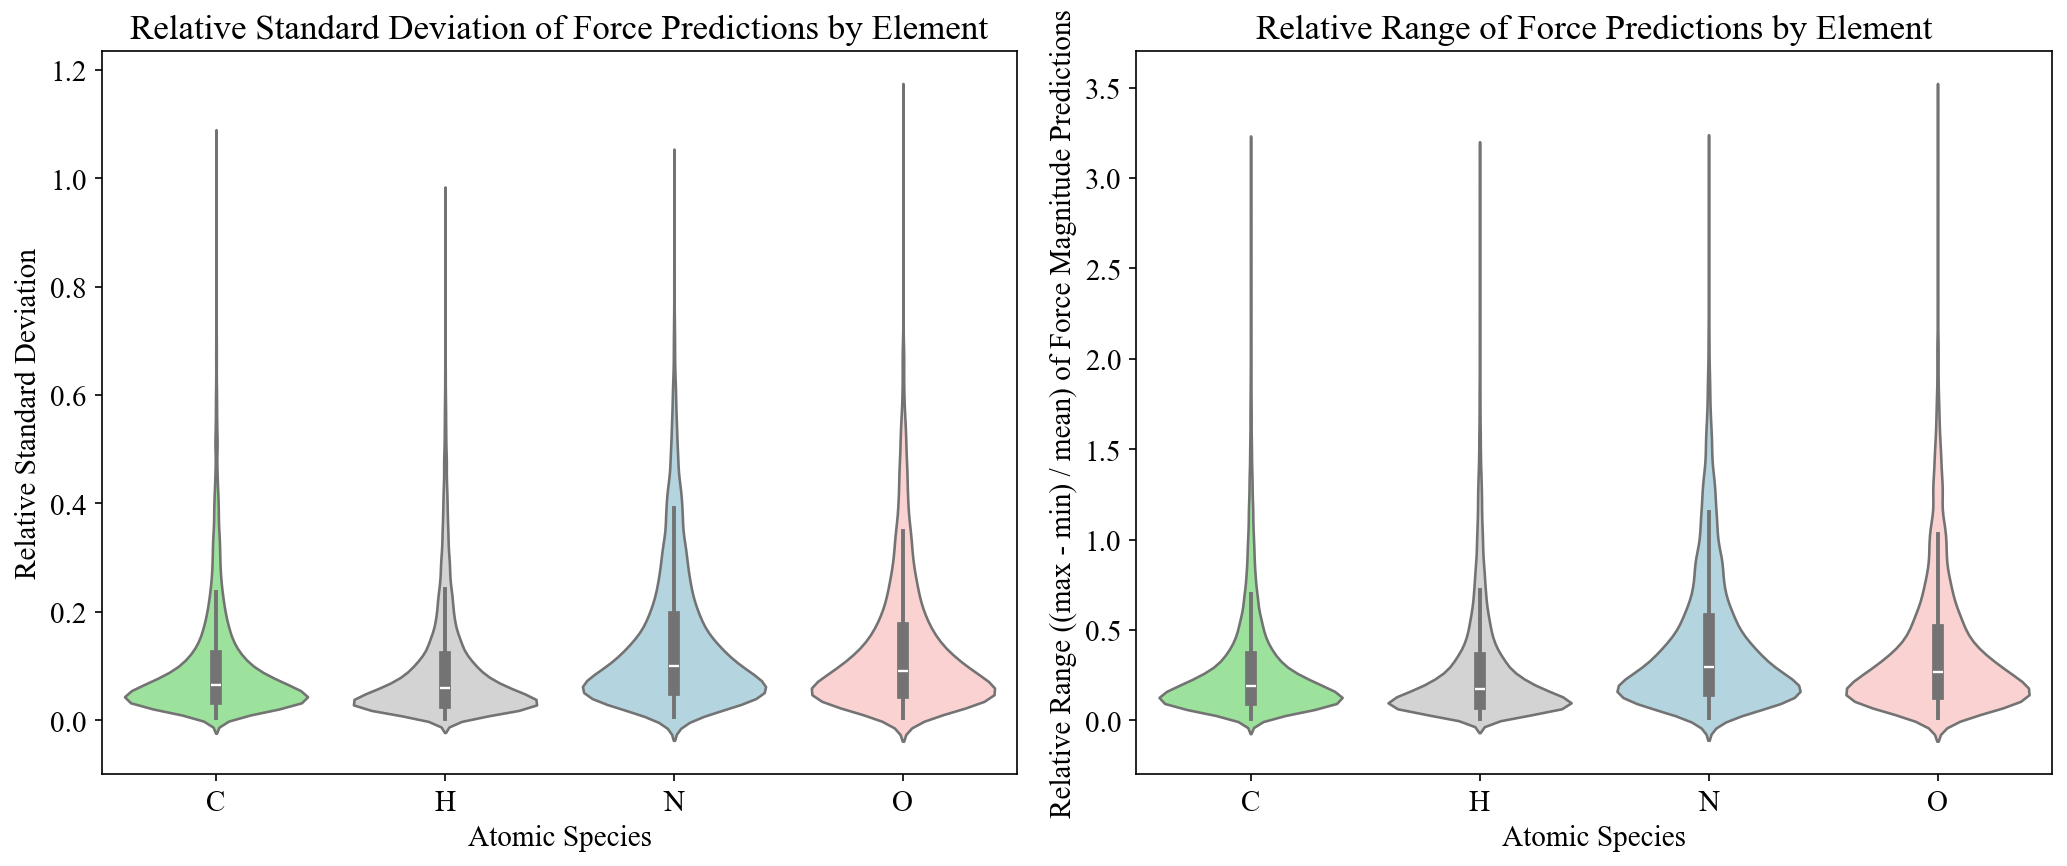

In [17]:
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}
df_long_stdev = df.explode("force_relative_stdev").reset_index(drop=True)
df_long_stdev["species"] = df.explode("species")["species"].reset_index(drop=True)
df_long_stdev["species"] = df_long_stdev["species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "black"))[0])

df_long_range = df.explode("force_relative_range").reset_index(drop=True)
df_long_range["species"] = df.explode("species")["species"].reset_index(drop=True)
df_long_range["species"] = df_long_range["species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "black"))[0])

species_color_map = {v[0]: v[1] for v in atom_types_colors.values()}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(ax=axes[0], data=df_long_stdev, x="species", y="force_relative_stdev", 
               hue="species", palette=species_color_map, order=['H', 'C', 'N', 'O'])

axes[0].set_xlabel("Atomic Species")
axes[0].set_ylabel("Relative Standard Deviation")
axes[0].set_title("Relative Standard Deviation of Force Predictions by Element")

sns.violinplot(ax=axes[1], data=df_long_range, x="species", y="force_relative_range", 
               hue="species", palette=species_color_map, order=['H', 'C', 'N', 'O'])

axes[1].set_xlabel("Atomic Species")
axes[1].set_ylabel("Relative Range ((max - min) / mean) of Force Magnitude Predictions")
axes[1].set_title("Relative Range of Force Predictions by Element")


plt.tight_layout()
plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define weight function (exponential to emphasize high-force atoms)
def compute_weighted_average(values, weights, alpha=1.0):
    """Compute weighted mean with exponential weighting."""
    exp_weights = np.exp(alpha * np.array(weights))  # Exponential weighting
    return np.sum(np.array(values) * exp_weights) / np.sum(exp_weights)

# Compute weighted averages for each molecule
weighted_stdev = []
weighted_range = []

for _, row in df.iterrows():
    # Compute weighted averages using force magnitudes as weights
    weighted_stdev.append(compute_weighted_average(row["force_relative_stdev"], row["mean_force_mag"], alpha=0.1))
    weighted_range.append(compute_weighted_average(row["force_relative_range"], row["mean_force_mag"], alpha=0.1))

# Store in DataFrame
df["weighted_force_stdev"] = weighted_stdev
df["weighted_force_range"] = weighted_range


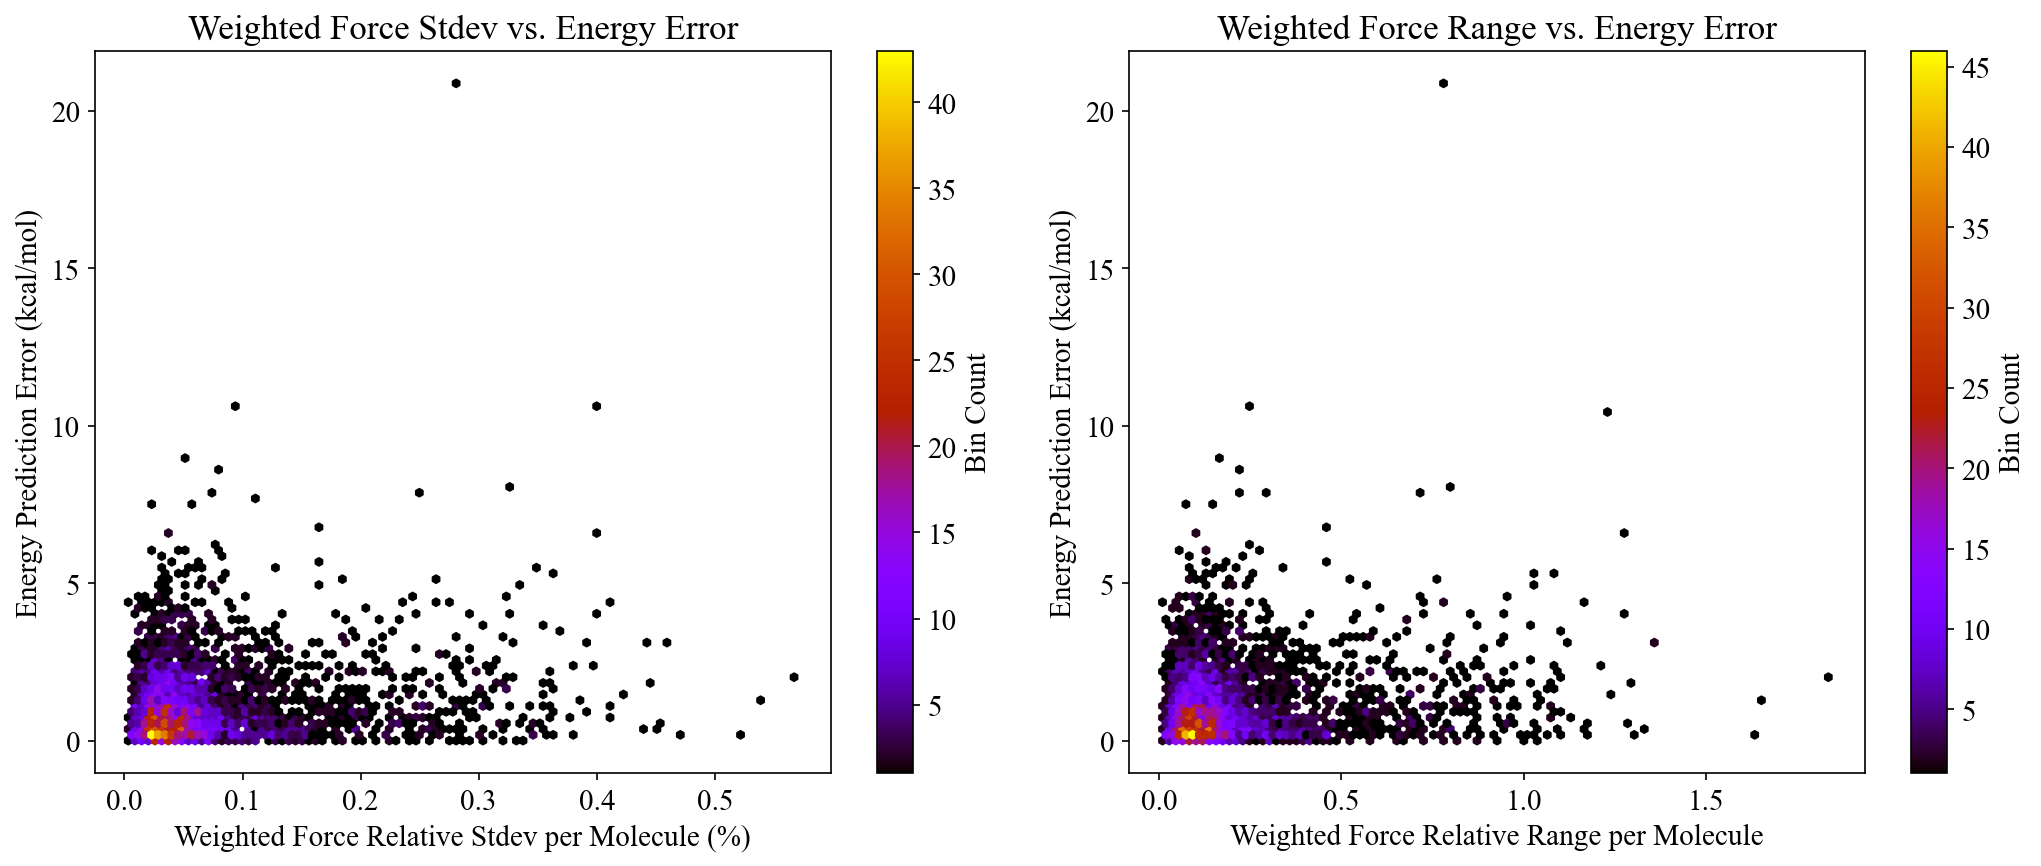

In [18]:
x_stdev = df["weighted_force_stdev"]
x_range = df["weighted_force_range"]
y_error = df["energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Weighted Force Relative Stdev per Molecule (%)")
axes[0].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[0].set_title("Weighted Force Stdev vs. Energy Error")
cb1 = fig.colorbar(hb1, ax=axes[0])
cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Weighted Force Relative Range per Molecule")
axes[1].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[1].set_title("Weighted Force Range vs. Energy Error")
cb2 = fig.colorbar(hb2, ax=axes[1])
cb2.set_label("Bin Count")

plt.tight_layout()
plt.show()


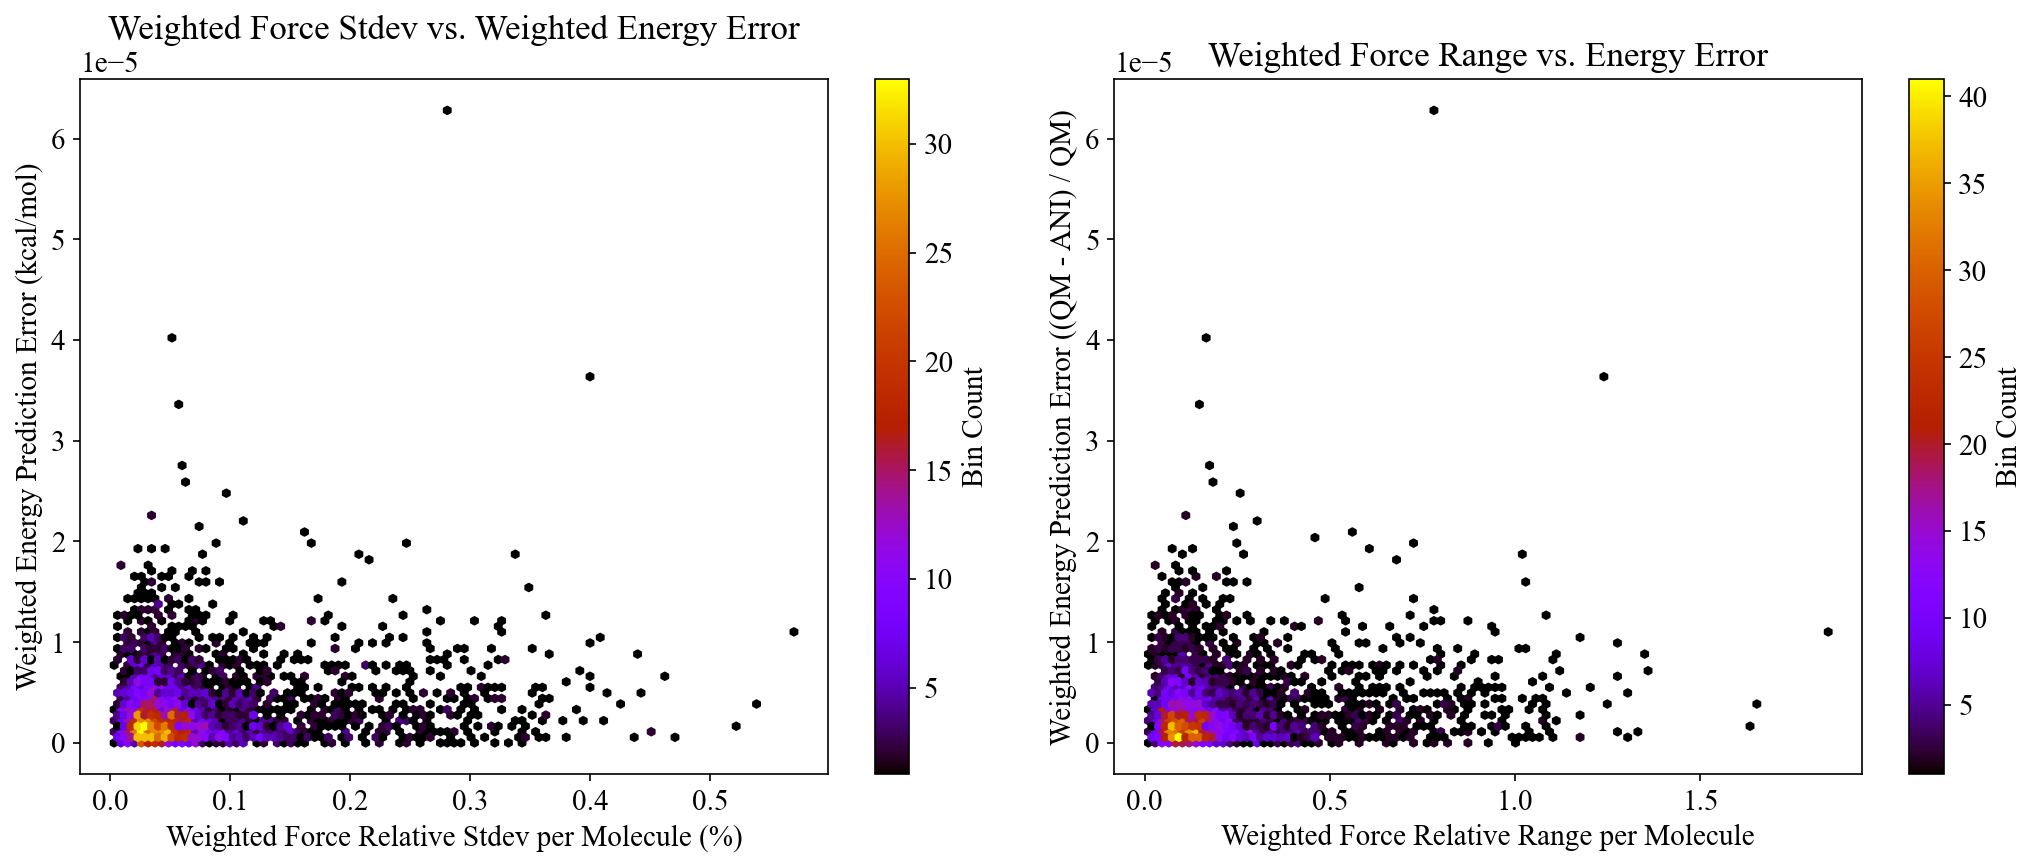

In [19]:
x_stdev = df["weighted_force_stdev"]
x_range = df["weighted_force_range"]
y_error = df["weighted_energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Weighted Force Relative Stdev per Molecule (%)")
axes[0].set_ylabel("Weighted Energy Prediction Error (kcal/mol)")
axes[0].set_title("Weighted Force Stdev vs. Weighted Energy Error")
cb1 = fig.colorbar(hb1, ax=axes[0])
cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Weighted Force Relative Range per Molecule")
axes[1].set_ylabel("Weighted Energy Prediction Error ((QM - ANI) / QM)")
axes[1].set_title("Weighted Force Range vs. Energy Error")
cb2 = fig.colorbar(hb2, ax=axes[1])
cb2.set_label("Bin Count")

plt.tight_layout()
plt.show()


In [20]:
df.iloc[0]

id                                                              C10H10-0-idx0
species                     [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...
dataset_energy                                                 -242773.384193
dataset_force_magnitudes    [87.38561144354274, 59.83847293938178, 47.3917...
energy_mean                                                    -242770.389571
energy_qbc                                                           0.114157
atomic_energies             [[-187.05026643226753, -179.4480629077964, -19...
mean_atomic_energies        [-175.1142937368321, -169.86167655852762, -188...
stdev_atomic_energies       [6.498004608968412, 4.537670540024433, 5.80158...
force_magnitudes            [[100.49569302106978, 60.00026246534715, 45.71...
force_relative_stdev        [0.027946410700678825, 0.0497141107916832, 0.0...
force_relative_range        [0.0848284587264061, 0.12420666217803955, 0.11...
mean_relative_stdev                                             

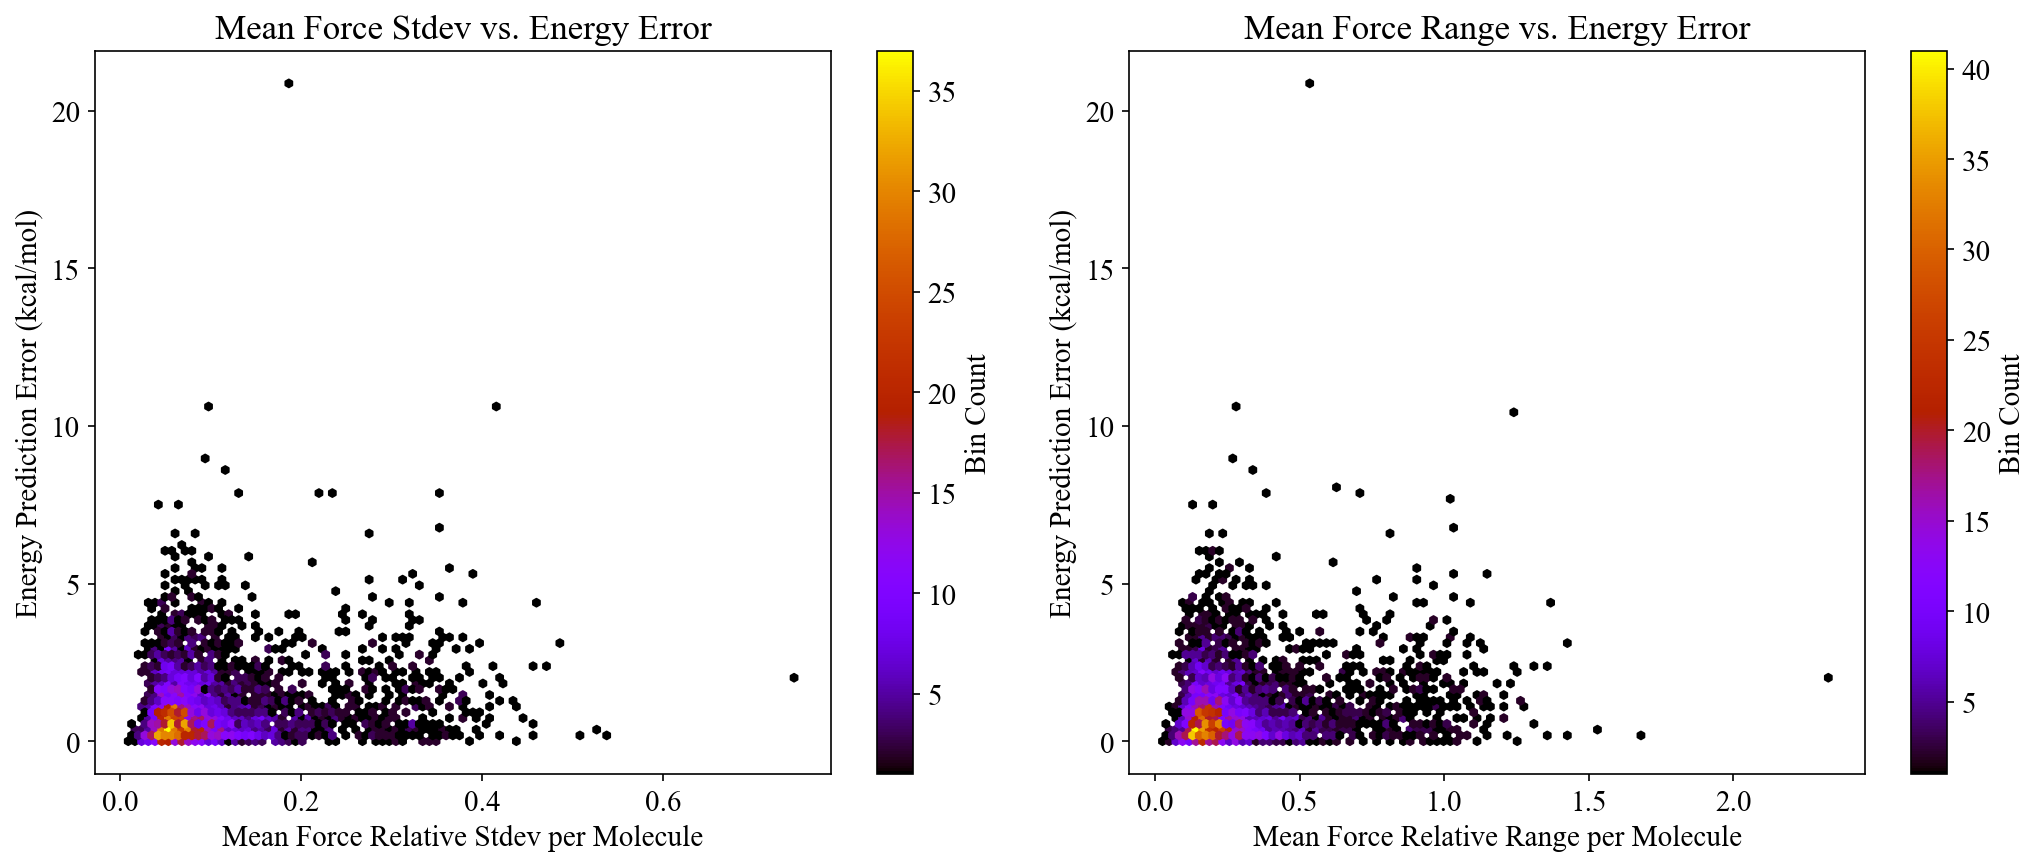

In [21]:
x_stdev = df["mean_relative_stdev"]
x_range = df["mean_relative_range"]
y_error = df["energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Mean Force Relative Stdev per Molecule")
axes[0].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[0].set_title("Mean Force Stdev vs. Energy Error")
cb1 = fig.colorbar(hb1, ax=axes[0])
cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Mean Force Relative Range per Molecule")
axes[1].set_ylabel("Energy Prediction Error (kcal/mol)")
axes[1].set_title("Mean Force Range vs. Energy Error")
cb2 = fig.colorbar(hb2, ax=axes[1])
cb2.set_label("Bin Count")

plt.tight_layout()
plt.show()

In [22]:
df

,id,species,dataset_energy,dataset_force_magnitudes,energy_mean,energy_qbc,atomic_energies,mean_atomic_energies,stdev_atomic_energies,force_magnitudes,force_relative_stdev,force_relative_range,mean_relative_stdev,mean_relative_range,mean_force_mag,energy_error,weighted_energy_error,weighted_force_stdev,weighted_force_range
0,C10H10-0-idx0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...",-242773.384193,"[87.38561144354274, 59.83847293938178, 47.3917...",-242770.389571,0.114157,"[[-187.05026643226753, -179.4480629077964, -19...","[-175.1142937368321, -169.86167655852762, -188...","[6.498004608968412, 4.537670540024433, 5.80158...","[[100.49569302106978, 60.00026246534715, 45.71...","[0.027946410700678825, 0.0497141107916832, 0.0...","[0.0848284587264061, 0.12420666217803955, 0.11...",0.040578,0.118680,"[98.80956470955209, 61.21855472183821, 45.1137...",2.994622,1.233505e-05,0.013924,0.034813
1,C10H10N2-0-idx0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...",-311527.751496,"[18.98149503642966, 18.055290168047268, 20.414...",-311527.105123,0.038300,"[[-212.86813191162815, -179.47261763544662, -1...","[-195.49920598401852, -176.1667621014158, -180...","[8.954507695410705, 1.8461102575884247, 3.7513...","[[16.77756467826385, 19.83721605475018, 20.410...","[0.08338917046785355, 0.3844622075557709, 0.13...","[0.26050177216529846, 1.0610047578811646, 0.43...",0.136744,0.402634,"[17.4110782295563, 13.599958666165062, 18.7244...",0.646373,2.074850e-06,0.118998,0.360345
2,C10H10N2O-0-idx0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...",-358668.660526,"[130.32000105831605, 51.28358326032442, 68.333...",-358666.475490,0.181636,"[[-200.31754297535184, -178.85197959544095, -1...","[-184.84739131109396, -174.2501094529661, -177...","[8.393670960057143, 2.7681069400499188, 2.4527...","[[145.29405440358676, 46.64345841278572, 63.89...","[0.012904064729809761, 0.0972728356719017, 0.0...","[0.043295759707689285, 0.25895193219184875, 0....",0.072155,0.208050,"[145.9493259705823, 46.927159724640305, 68.340...",2.185036,6.092073e-06,0.013003,0.043551
3,C10H10N2O2-0-idx0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...",-405838.670608,"[44.37238807941298, 94.11790493553391, 57.3449...",-405836.811520,0.187818,"[[-202.86281909313445, -178.02609545036216, -1...","[-187.87465447817496, -174.946992446993, -169....","[7.85866531195937, 2.096307129796542, 0.883811...","[[42.18104341432271, 98.06838432295018, 47.730...","[0.01173018291592598, 0.06175226345658302, 0.1...","[0.032780569046735764, 0.1863730400800705, 0.2...",0.065179,0.191260,"[43.00073744907994, 94.04876325080544, 57.4694...",1.859088,4.580855e-06,0.039896,0.110891
4,C10H10N4-0-idx0,"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, ...",-380190.869046,"[102.01173827514943, 25.88290894324457, 43.512...",-380192.264193,0.094926,"[[-208.822661050988, -185.97268230284436, -185...","[-191.46544209939435, -183.27738484065205, -17...","[8.895050610450765, 2.204080912820189, 3.71839...","[[101.08983140450245, 26.246320230183226, 47.8...","[0.010601980611681938, 0.11936498433351517, 0....","[0.03239946812391281, 0.3854621350765228, 0.27...",0.062380,0.184290,"[101.99143920654748, 25.40028433056248, 46.866...",1.395147,3.669597e-06,0.019171,0.057720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,N2O3-0-idx0,"[7, 7, 8, 8, 8]",-210089.944305,"[134.33221902439274, 137.29755579554987, 108.6...",-210090.183348,0.472673,"[[-106.89768838778384, -111.09239514076876, -4...","[-107.92086126046802, -109.67619701576412, -34...","[1.2085364187938143, 0.9067102453469302, 4.963...","[[100.72156659346827, 112.2649815675743, 151.7...","[0.18171578645706177, 0.15906251966953278, 0.2...","[0.5409694910049438, 0.4573656916618347, 0.912...",0.223366,0.676530,"[136.17976916081048, 137.09881469999436, 132.6...",0.239044,1.137816e-06,0.298821,0.841996
3110,N4-0-idx0,"[7, 7, 7, 7]",-137422.975442,"[11.731601822498185, 11.313463889750777, 6.479...",-137422.745950,0.105310,"[[-110.63

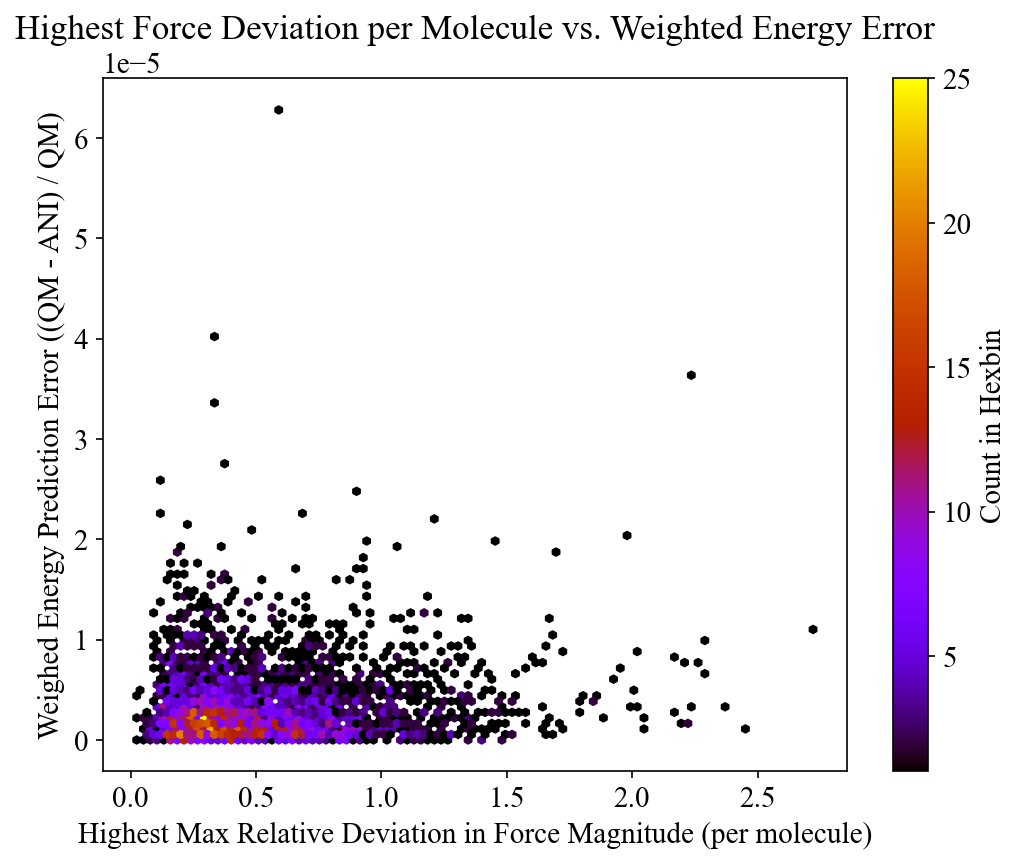

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

relative_max_deviations = []

for _, row in df.iterrows():
    species = row["species"]  # Atomic species per atom
    force_magnitudes = np.array(row["force_magnitudes"])  # Shape: (8, N_atoms)
    mean_force = np.mean(force_magnitudes, axis=0)  # Mean over ensemble, shape: (N_atoms,)

    mean_force[mean_force == 0] = np.nan  # Set zeros to NaN to avoid division errors

    max_relative_deviation = np.nanmax(np.abs(force_magnitudes - mean_force) / mean_force, axis=0)

    for atom_idx, rel_deviation in enumerate(max_relative_deviation):
        relative_max_deviations.append([
            row["id"], species[atom_idx], rel_deviation, row["weighted_energy_error"]
        ])

df_relative_max_dev = pd.DataFrame(
    relative_max_deviations, columns=["id", "species", "max_relative_force_deviation", "weighted_energy_error"]
)

df_max_per_molecule = df_relative_max_dev.loc[
    df_relative_max_dev.groupby("id")["max_relative_force_deviation"].idxmax()
]

plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    df_max_per_molecule["max_relative_force_deviation"], 
    df_max_per_molecule["weighted_energy_error"], 
    gridsize=100, cmap="gnuplot", mincnt=1
)

plt.colorbar(hb, label="Count in Hexbin")
plt.xlabel("Highest Max Relative Deviation in Force Magnitude (per molecule)")
plt.ylabel("Weighed Energy Prediction Error ((QM - ANI) / QM)")
plt.title("Highest Force Deviation per Molecule vs. Weighted Energy Error")
plt.show()
